In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import sys
from dataclasses import dataclass
import random as r
from matplotlib import pyplot as plt

import jax
from jax import Array, numpy as jnp, random as jrand
import keras as nn
nn.utils.set_random_seed(812)
import tensorflow as tf

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())

env: TF_CPP_MIN_LOG_LEVEL=3
Python Version 3.11.7 (main, Dec  8 2023, 18:56:58) [GCC 11.4.0]
Keras Version 3.0.4 with jax backend 	Jax Version 0.4.23
Jax backend device gpu


# Positional Embeddings

In [2]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T

        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)

    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = jnp.repeat(self.pos_emb[..., None, ::2], repeats=2, axis=-1)
        cos_freqs = jnp.repeat(self.pos_emb[..., None, 1::2], repeats=2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

# Attention

In [3]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        n_heads:int
        d_model:int
        maxlen:int
        dropout_rate:float
    Input:
        inp2q: shape(B, N, d_model)
        inp2k: shape(B, T, d_model)
        inp2v: shape(B, T, d_model)
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            num_heads:int,
            d_model:int,
            maxlen:int,
            dropout_rate:float,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0
        self.causal = causal
        self.num_heads = num_heads
        self.d_model = d_model
        self.dim = self.d_model//num_heads

        self.wq = nn.layers.Dense(self.d_model, use_bias=False)
        self.wk = nn.layers.Dense(self.d_model, use_bias=False)
        self.wv = nn.layers.Dense(self.d_model, use_bias=False)
        self.attwei_dropout = nn.layers.Dropout(dropout_rate)

        self.w = nn.layers.Dense(d_model)
        if causal:
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, maxlen, maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            inp2q:Array, # (B, T, d_model)
            inp2k:Array, # (B, T, d_model)
            inp2v:Array, # (B, T, d_model)
    ):
        B, T = inp2q.shape[:-1]
        assert inp2k.shape == inp2v.shape == inp2q.shape

        # compute q, k, v
        q = self.wq(inp2q) # (B, T, d_model)
        k = self.wk(inp2k) # (B, T, d_model)
        v = self.wv(inp2v) # (B, T, d_model)

        # seperate heads
        q = q.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        k = k.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)
        v = v.reshape((B, self.num_heads, T, self.dim)) # (B, h, T, dim)

        # compute attention weights
        att_wei = (q @ k.transpose((0, 1, 3, 2)))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
        if self.causal:
            att_wei = att_wei + self.causal_mask[:, :, :T, :T] # (B, h, T, T)

        att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
        att_wei = self.attwei_dropout(att_wei)

        # apply attention weights to v
        att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)
        # combine heads
        att_out = att_out.reshape((B, T, self.d_model)) # (B, T, h*dv) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.w(att_out) # (B, T, d_model)
        return linear_att_out

# GPT

In [4]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1])
    ); del blabla
    return model


class TieWeights(nn.Layer):
    def __init__(self, dense:nn.Layer, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense # (1, vocab_size, d_model)
        self.activation = nn.activations.get(activation)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.dense.weights)[0].T # (d_model, vocab_size)
        return self.activation(x @ W)


class Block(nn.Model):
    """```
    Block
    Args:
        causal:bool
        num_heads:int
        d_model:int
        maxlen:int
        dropout_rate:float
        use_bias:bool
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal: bool, 
            num_heads: int, 
            d_model: int,
            maxlen:int,
            dropout_rate: float,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*d_model
        self.rmsnorm1 = nn.layers.LayerNormalization(rms_scaling=True, epsilon=1e-5)
        self.rmsnorm2 = nn.layers.LayerNormalization(rms_scaling=True, epsilon=1e-5)

        self.mha = Attention(causal, num_heads, d_model, maxlen, dropout_rate)

        self.ffn = [
            nn.layers.Dense(int(dff_in), use_bias=True),
            nn.layers.Activation(nn.activations.gelu),
            nn.layers.Dense(d_model, use_bias=True),
            nn.layers.Dropout(dropout_rate)
        ]
        
        self.dropout = nn.layers.Dropout(dropout_rate)

    def call(self, inputs:Array):
        z = self.rmsnorm1(inputs)
        x = inputs+self.mha(z, z, z)

        z = self.rmsnorm2(x)
        for layer in self.ffn:
            z = layer(z)
        outputs = x + z
        return outputs # (B, T, d_model)

In [5]:
class GPT(nn.Model):
    """```
    GPT!!
    Args:
        args:
            d_model: int
            num_heads: int
            num_layers: int
            max_context_length: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            dropout_rate: float
        causal:bool
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, args, causal:bool, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if args.output_units is None:
            args.output_units = args.vocab_size
        # pos embedding
        self.pos_embed = nn.layers.Embedding(args.max_context_length, args.d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(args.dropout_rate)
        self.token_embed = nn.layers.Embedding(args.vocab_size, args.d_model)

        # block layers
        self.block_layers = [
                Block(
                    causal=causal, 
                    num_heads=args.num_heads,
                    d_model=args.d_model,
                    maxlen=args.max_context_length,
                    dropout_rate=args.dropout_rate,
                ) for _ in range(args.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(rms_scaling=True)
        self.linear = nn.layers.Dense(args.output_units, activation=output_activation, use_bias=True) #TieWeights(self.token_embed, activation=output_activation)
        self.logits_dropout = nn.layers.Dropout(rate=args.dropout_rate)

    def call(
            self, 
            inputs:Array
    ):
        # embed tokens
        x = self.emb_dropout(self.token_embed(inputs)+self.pos_embed(jnp.arange(inputs.shape[-1]))) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return self.logits_dropout(logits)

# Dataset

In [6]:
shakespeare_url = "https://homl.info/shakespeare"
filepath = nn.utils.get_file("shakespeare.txt", shakespeare_url)
shakespeare_text = open(filepath, "r", encoding="utf-8").read()

In [7]:
print(shakespeare_text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [8]:
chars = sorted(list(set(shakespeare_text)))
VOCAB_SIZE = len(chars)
print(''.join(chars))
print(VOCAB_SIZE)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [9]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [10]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode(shakespeare_text[:100]))
print(decode(encode(shakespeare_text[:100])))

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56, 1, 51, 43, 1, 57, 54, 43, 39, 49, 8, 0, 0, 13, 50, 50, 10, 0, 31, 54, 43, 39, 49, 6, 1, 57, 54, 43, 39, 49, 8, 0, 0, 18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 37, 53, 59]
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# GPT Args

In [11]:
@dataclass
class GPTArgs:
    """GPT Configuration"""
    d_model:int = 128                       
    num_layers:int = 4
    num_heads:int = 8
    max_context_length:int = 64
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.4

GPTArgs()

GPTArgs(d_model=128, num_layers=4, num_heads=8, max_context_length=64, vocab_size=65, output_units=None, dropout_rate=0.4)

In [12]:
model = GPT(GPTArgs, causal=True)
model = build_model(model, (2, GPTArgs.max_context_length), [0, GPTArgs.vocab_size-1])
model.summary()

Model: "gpt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                         │      8,192 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ ?                         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ embedding_1 (Embedding)         │ ?                         │      8,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block (Block)                   │ ?                         │    197,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_1 (Block)                 │ ?                         │    197,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_2 (Block)                 │ ?                         │    197,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block_3 (Block)                 │ ?                         │    197,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ layer_normalization_8           │ ?                         │        128 │
│ (LayerNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_24 (Dense)                │ ?                         │      8,385 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ ?                         │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 815,553 (3.11 MB)

 Trainable params: 815,553 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

# Training Arguments

In [13]:
@dataclass
class TArgs:
    "Training Arguments"
    checkpoint:str = "weights/gpt_shakespeare2/Epoch{epoch}.weights.h5"
    steps_per_epoch:int = 250
    eval_steps = 200
    
    batch_size:int = 64
    num_steps:int = 10_000
    epochs:int = num_steps//steps_per_epoch

    init_lr:float = 8e-4
    max_lr:float = 1e-3
    min_lr:float = 1e-4
    warmup_steps:int = 100
    decay_steps:int = 85*num_steps//100

    beta1:float = 0.9
    beta2:float = 0.99
    clipvalue:float = 1e0
    weight_decay:float = 1e-1

In [14]:
data = encode(shakespeare_text)
datasets = {"train": to_dataset(data[:1_000_000], length=GPTArgs.max_context_length, shuffle=True, batch_size=TArgs.batch_size, seed=42), # ~90%split
            "val": to_dataset(data[1_000_000:], length=GPTArgs.max_context_length, shuffle=True, batch_size=TArgs.batch_size, seed=0)}
print(datasets)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>, 'val': <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>}


# Model, lr schedule, compile and training

In [15]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.max_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
    alpha=TArgs.min_lr/TArgs.max_lr
)

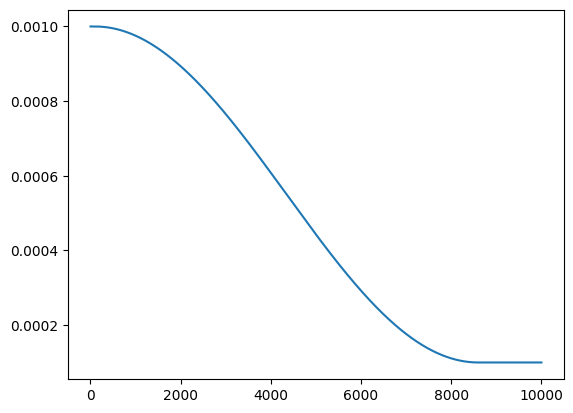

In [16]:
steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs); del lrs, steps
plt.show()

In [17]:
model.compile(
    optimizer=nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2, 
        clipvalue=TArgs.clipvalue, 
        weight_decay=TArgs.weight_decay
    ),
    loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True),
)

In [18]:
def sample_top_k(key, logits, k):
    topk_logits, topk_idx = jax.lax.top_k(logits, k=k)
    idx = jrand.categorical(key, topk_logits)
    return topk_idx[0][idx]


def generate(idx:Array, max_new_tokens:int, top_k:int|None=None, seed:int=42):    
    key = jrand.PRNGKey(seed)
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -GPTArgs.max_context_length:] # (B, T)
        logits = model(idx_cond, training=False)[:, -1, :]/0.89 # (B, T, vocab_size)[:, -1, :] => (B, vocab_size)
        idx_next = jrand.categorical(key, logits) if top_k is None else sample_top_k(key, logits, k=top_k) # (B, 1)
        key, _ = jrand.split(key)
        idx = jnp.concatenate((idx, idx_next[None]), axis=-1) # (B, T+1)
    return idx.tolist()[0]


saveW = nn.callbacks.ModelCheckpoint(
    filepath=TArgs.checkpoint,
    save_weights_only=True
)
early_stop = nn.callbacks.EarlyStopping(
    patience=7,
    restore_best_weights=True,
)

# class DisplayCallback(nn.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print("\n")
#         print(decode(generate(idx=jnp.array([[0.]]), max_new_tokens=100, top_k=10, seed=epoch)))
#         print("\n")
#         return

In [19]:
history = model.fit(
    x=datasets["train"],
    epochs=TArgs.epochs,
    steps_per_epoch=TArgs.steps_per_epoch,
    validation_data=datasets["val"],
    callbacks=[saveW, early_stop], #DisplayCallback()]
)

Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 2.5694 - val_loss: 2.3311
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.7354 - val_loss: 2.3002
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.6211 - val_loss: 2.2819
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5792 - val_loss: 2.2115
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5687 - val_loss: 2.1711
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5484 - val_loss: 2.1704
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5342 - val_loss: 2.1764
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.5196 - val_loss: 2.1637
Epoch 9/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5024 - val_loss: 2.1545
Epoch 10/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.4889 - val_loss: 2.1383
Epoch 11/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.4855 - val_loss: 2.1404
Epoch 12/40
250/250 ━━━━━━━━━━━━━━━━━━━━

In [20]:
print(decode(generate(idx=jnp.array([[29]]), max_new_tokens=1000, seed=42, top_k=None)))

Qonom owingh cload you, whips, anddes a ditoners oe-Fr-widacrilness to appear thy shame; let heart, Warwick from the baiter and many feigned by thy grace and laughed there's a dust thou liest, and what kill my lord?

KING RICHARD:
When no fight.

CLARENCE:
Who bleance is this that we have, madam: I have to-night.
But
Ay, young was yourselfsame we are we dear blows. I'll tell we have shadeth the reason but forces to deposed!
I can grandsire,
And in your trumpets,
That dear.

WARWICK:
And set our hearts of the stronger.

POLIXENES:
She't nothing to assist the liphanity, take out of him to bed!
And, I am no sour houses?
O, stand he is suppose,
Were is thee, sir.

LEONTES:
Hereford, murder for me answer
Before King Henry, haught of nature shall arraRosliyed of these law in my soul to myself, a lectation of his majesty
Myself a taily in thy Lammas-sight,
And I cannot answer made him so untimely friend, as we hewd disinherit to be there?

HASTINGS:
We shows me, but I'll warrant and stay:
You

In [21]:
print(decode(generate(idx=jnp.array([[20.]]), max_new_tokens=1000, seed=98857745, top_k=10)))

He, bomby. its wiprich ones bear now then at.'

RORIRICHASNMTIMsS:
You are throne, being to die,
Open these
Is lay the suppose to tent; and not be his fear this seek them and
To help! my soul!
See, razing thou art from his sorrow,
Shall be thousands uses into the traitor's
As thou would nothing blood at is the self.

OXFORD:
Now, my lord,
Whose honour's face;
For that thou deny to hriek
Of my breast of the princely eyes
That we have left came from the park to myself?

WARWICK:
She's from this arm up the
Enfranchisements of me
May shot seld with death,
I have done, master die.

POLIXENES:
Why thee seldom proceeders,
Which we will assured at the say the dulleshines that this place
I' quarrel was with me some for brother ancestor, be viand howlrn;
And, as mine.

KING HENRY VI:
What sleep, and as falling on the taunts he was to make me these honourably threat thus toward the shall we met then bring your me got wantings insulting tempeach my friendly,
Bulo, thou could day by complices, as m

In [22]:
print(decode(generate(idx=jnp.array([[0.]]), max_new_tokens=2000, seed=12212, top_k=None)))


lon
I myfento bean wault
With onever clase?s sucar,
His sigh treason carries and trumpets!

PRINCE EDWARD IV:
But Warwick. Well, my lord, liether spite of ill-shaped on the king was thine every thing;
And sting,
And make your house
Be and his native the cure of the abject,
And set thy crown.

KING HENRY VI:
What call King Lewis unto the queen
Romeo's hand this sin
Hast to creature in tenter'd jot.

KING EDWARD IV:
I will not pectacle thinks it none inforce we favour'd, and not ceaming common doth swell: even you shall remains,--but lies
Not safeget;
And that rough for this:
And, murder, my lords, to yours, if Warwick by tongue,
And do it.

LEONTES:
A blind they to see thing Tybalt;
And what's a dauphin is thy face,
Writ in that she's could, do evention may brothers daggers than you like to ours must have been wappear to a hown.

CLARENCE:
Why, lords, there is no thou there is no stops this world forget young Rosaling show'd you slow, with the sight.

POLIXENES:
Brother for one?

Secon